<a href="https://colab.research.google.com/github/ymohamedahmed/drbayes/blob/master/SIBDL_demo_group_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Seminars - Subspace Inference for Bayesian Deep Learning - Demo

*Reviewed by Chiara Campagnola, Yousuf Mohamed-Ahmed and Hannah Teufel*

**Aims of this notebook**:
- Empirically evaluate the effectiveness of the uncertainty estimates produced (this is **not** evaluated by the paper)
- Evaluate the performance gains achieved by applying approximate inference techniques in subspaces *vs* in the full space
<!-- - Compare the method proposed by the paper to non-neural network based approaches -->

**Research questions**:
- In comparison to ensembles and 'full' variational inference (VI); how well does VI in PCA subspace perform in terms of uncertainty estimates (measured by [expected calibration error](https://arxiv.org/pdf/1706.04599.pdf) and out-of-distribution uncertainty estimates).
- Using the same comparisons, how does 'performance' of the paper stack up? 

## Setup

In [17]:
!rm -rf drbayes
!git clone https://github.com/ymohamedahmed/drbayes.git

Cloning into 'drbayes'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 365 (delta 51), reused 56 (delta 21), pack-reused 261
Receiving objects: 100% (365/365), 15.17 MiB | 37.51 MiB/s, done.
Resolving deltas: 100% (121/121), done.


In [18]:
!pip install -e drbayes

Obtaining file:///content/drbayes
  Found existing installation: subspace-inference 0.0
    Can't uninstall 'subspace-inference'. No files were found to uninstall.
  Running setup.py develop for subspace-inference


In [19]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.utils.data
from torch.nn import functional as F
import torch.nn as nn
from torchvision import datasets, transforms

import seaborn as sns

import subspace_inference
import subspace_inference.utils as utils
from subspace_inference.posteriors import SWAG
from subspace_inference import models, losses, utils
from subspace_inference.models import MLP
from subspace_inference.visualization import plot_predictive
from subspace_inference.posteriors.proj_model import SubspaceModel
from tqdm.notebook import tqdm
from subspace_inference.posteriors.vi_model import VIModel, ELBO
import math

import os

torch.backends.cudnn.benchmark = True
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [57]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
train_all = datasets.QMNIST(root="../data",train=True, download=True,
                   transform=transform)
train_val_split = int(0.8*len(train_all))
train_idx, val_idx = range(0, train_val_split), range(train_val_split, len(train_all))

train = torch.utils.data.Subset(train_all, train_idx)
val = torch.utils.data.Subset(train_all, val_idx)
test = datasets.QMNIST('../data', train=False,download=True,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(train,batch_size=512)
val_loader = torch.utils.data.DataLoader(val,batch_size=512)

In [22]:
class VanillaMLP(nn.Module):
  def __init__(self, dims):
    super(VanillaMLP,self).__init__()
    self.dims = dims
    layers = [nn.Flatten()] + [lay for (x,y) in zip(dims[:-1],dims[1:]) for lay in [nn.Linear(x,y), nn.ReLU()] ]
    layers.pop()
    self.model = nn.Sequential(*layers)

  def forward(self,x):
    return self.model(x)

## Models

In [28]:
def loss_acc(model, loss_function, loader):
  N = 0
  total_loss = 0
  acc = 0
  for x,y in loader:
    x = x.to(device)
    y = y.to(device)

    out = model(loader)
    loss = loss_function(out,y)
    total_loss += loss.item()
    acc += (out==y).sum()
    N += x.size(0)
  return loss/N, acc/N

def convergence(val_losses):
  return len(val_losses) > 10 and val_losses[-1] <= val_losses[-10]

def train(model, loss_function, max_epochs, train_loader):
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  swag_model = SWAG(VanillaMLP, subspace_type="pca",
                  subspace_kwargs={"max_rank": 10, "pca_rank": 10},dims=[28*28,50,20,10])
  for epoch in range(max_epochs):
    total_loss = 0
    for x,y in train_loader:
      x = x.to(device)
      y = y.to(device)
      optimizer.zero_grad()
      out = model(x)
      swag_model.collect_model(model)

      loss = loss_function(out,y).item() 
      loss.backward()
      optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss}")

  torch.save(swag_model, "drbayes/swag_model_qmnist.pt")
  return swag_model.get_space()

def train(model, loss_function, max_epochs, train_loader, val_loader, lr, swag=False):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  vlosses = []
  if swag:
    swag_model = SWAG(VanillaMLP, subspace_type="pca",
                    subspace_kwargs={"max_rank": 10, "pca_rank": 10},dims=model.dims)
  pbar = tqdm(range(max_epochs))
  for epoch in pbar:
    for x,y in train_loader:
      x = x.to(device)
      y = y.to(device)
      optimizer.zero_grad()
      out = model(x)
      if swag: 
        swag_model.collect_model(model)
      loss = loss_function(model,x,y)[0]
      loss.backward()
      optimizer.step()
    vloss, vacc = loss_acc(model, loss_function, val_loader)
    vlosses.append(vloss)
    if convergence(losses):
      print("converged")
      break
    bar.set_description(f'loss: {vloss}')
    if epoch % 2 == 0:
        print(f"Epoch: {epoch}, loss: {vacc}")


### Mean Field Variational Inference

In [10]:
def number_of_params(dims):
  d = np.array(dims)
  return ((d[:-1]*d[1:])+d[1:]).sum()
init_sigma = 1.
prior_sigma = 1.
dims = [28*28,10]
criterion = losses.cross_entropy
temperature = 0.01
# number_params = len(.parameters())
number_params = number_of_params(dims)
print(number_params)
identity_space = SubspaceModel(torch.zeros(number_params), torch.eye(number_params))
full_vi_model = VIModel(
    subspace=identity_space,
    init_inv_softplus_sigma=math.log(math.exp(init_sigma) - 1.0),
    prior_log_sigma=math.log(prior_sigma),
    base=VanillaMLP,
    dims=dims
)
# print(full_vi_model)

# full_vi_model.to(device)

7850


In [33]:
full_vi_model.to(device)
elbo = ELBO(criterion, len(train_loader.dataset), temperature=temperature)
train_vi_model(full_vi_model, elbo, 50, train_loader,lr=0.01)
# torch.save(full_vi_model.state_dict(), "drbayes/full-vi-pca-model.pt")

Epoch: 0, loss: 0.0008180220577865838
Epoch: 2, loss: 0.000810457852979501
Epoch: 4, loss: 0.0008041149731104572
Epoch: 6, loss: 0.0007976021368056536
Epoch: 8, loss: 0.0007612998275707165
Epoch: 10, loss: 0.0007470322951674462
Epoch: 12, loss: 0.0007309044523785512
Epoch: 14, loss: 0.0007205517152945201
Epoch: 16, loss: 0.0007231044278790553
Epoch: 18, loss: 0.0007202681042253971
Epoch: 20, loss: 0.0007065397637585799
Epoch: 22, loss: 0.0007192969715843598
Epoch: 24, loss: 0.0007009561580295364
Epoch: 26, loss: 0.0007046009958411256
Epoch: 28, loss: 0.0006855234963198503
Epoch: 30, loss: 0.000671438501526912
Epoch: 32, loss: 0.0006922752710059285
Epoch: 34, loss: 0.0006819618388389548
Epoch: 36, loss: 0.000680034129632016
Epoch: 38, loss: 0.000664166567971309
Epoch: 40, loss: 0.0006560656376183033
Epoch: 42, loss: 0.0006687452895566821
Epoch: 44, loss: 0.0006390286854157845
Epoch: 46, loss: 0.0006788375919063887
Epoch: 48, loss: 0.0006550956812997659



In [55]:
train_vi_model(full_vi_model, elbo, 100, train_loader,lr=0.001)

Epoch: 0, loss: 0.0007026797382781903
Epoch: 2, loss: 0.0007042520966380834
Epoch: 4, loss: 0.0006989381814996402
Epoch: 6, loss: 0.0006977453984941045
Epoch: 8, loss: 0.0006972624263415734
Epoch: 10, loss: 0.0006914581285168728
Epoch: 12, loss: 0.0006926703689619899
Epoch: 14, loss: 0.0006893741205334663
Epoch: 16, loss: 0.0006884578088919321
Epoch: 18, loss: 0.0006856171811309953
Epoch: 20, loss: 0.000684600281342864
Epoch: 22, loss: 0.0006818366101011634
Epoch: 24, loss: 0.0006768600701354444
Epoch: 26, loss: 0.0006750988005350034
Epoch: 28, loss: 0.0006752999259158969
Epoch: 30, loss: 0.0006738073330062131
Epoch: 32, loss: 0.0006724552974104881
Epoch: 34, loss: 0.0006683868775765101
Epoch: 36, loss: 0.00066771533023566
Epoch: 38, loss: 0.0006656540175589423
Epoch: 40, loss: 0.0006639196455478668
Epoch: 42, loss: 0.0006621713461043934
Epoch: 44, loss: 0.0006600721725573142
Epoch: 46, loss: 0.0006594876303027073
Epoch: 48, loss: 0.0006562185333420833
Epoch: 50, loss: 0.00065560127704

In [17]:
torch.save(full_vi_model.state_dict(), "drbayes/full-vi-pca-model.pt")

In [56]:
num_evals = 1000
test_batch_size = 512
test_loader = torch.utils.data.DataLoader(test,batch_size=test_batch_size)
num_classes = 10
preds = torch.zeros((len(test_loader.dataset), num_classes))
# preds = preds.to(device)
print(len(test_loader.dataset))
for n, (x,_) in tqdm(enumerate(test_loader)):
  x = x.to(device)
  for i in range(num_evals):
    preds[n*test_batch_size:(n+1)*test_batch_size] += F.softmax(full_vi_model(x).cpu(),dim=1)
  del x 
  torch.cuda.empty_cache()
preds = 1/num_evals*preds
print((1.*torch.argmax(preds, dim=1).eq(test_loader.dataset.targets[:,0])).mean())

60000



tensor(0.8970)


tensor([0.2817, 0.2819, 0.2891, 0.2958, 0.2993, 0.3038, 0.3043, 0.3058, 0.3160,
        0.3179], grad_fn=<IndexBackward>)


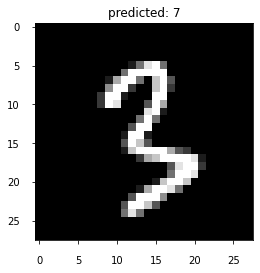

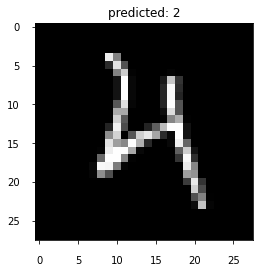

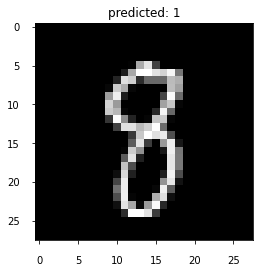

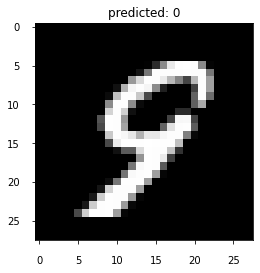

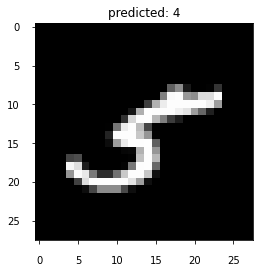

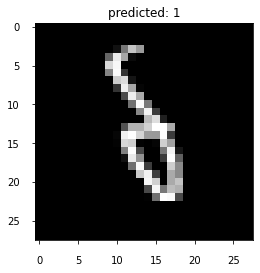

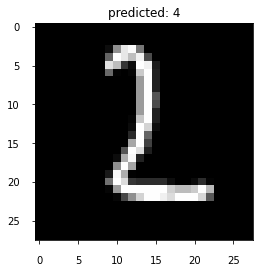

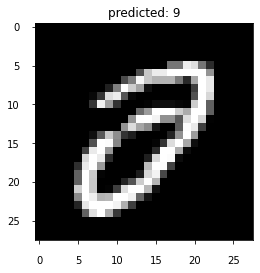

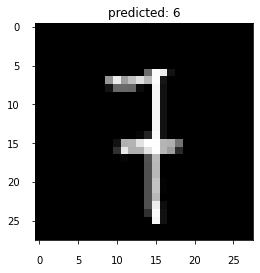

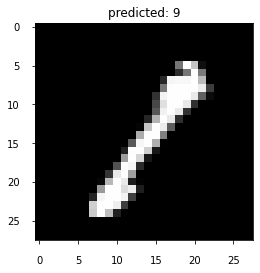

In [58]:
inds = torch.max(preds,dim=1)[0].argsort()[:10]
print(torch.max(preds,dim=1)[0][inds])
for i,im in enumerate(test_loader.dataset.data[inds]):
  plt.imshow(im,cmap='gray')
  plt.title(f'predicted: {preds[i].argmax()}')
  plt.show()

### Ensembles

### Neural network + Bayesian Linear Regression

### _SIBDL_: PCA subspace

In [9]:
model = VanillaMLP([28*28,50,20,10])
model.to(device)

VanillaMLP(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=50, bias=True)
    (2): ReLU()
    (3): Linear(in_features=50, out_features=20, bias=True)
    (4): ReLU()
    (5): Linear(in_features=20, out_features=10, bias=True)
  )
)

In [10]:
space = pretrain_mlp(model, F.cross_entropy, 100, train_loader)
torch.save(model.state_dict(), "drbayes/MLP-qmnist.pt")
mean, _, cov_factor = space
subspace = SubspaceModel(mean, cov_factor)
torch.save(subspace.state_dict(), "drbayes/pca-subspace-qmnist.pt")

Epoch: 0, loss: 0.00497192470356822
Epoch: 10, loss: 0.0024160456378012896
Epoch: 20, loss: 0.0017338517354801297
Epoch: 30, loss: 0.0021731380838900805
Epoch: 40, loss: 0.0001031545689329505
Epoch: 50, loss: 8.925090514821932e-05
Epoch: 60, loss: 0.0005254982970654964
Epoch: 70, loss: 0.0007059096824377775
Epoch: 80, loss: 0.00010775399277918041
Epoch: 90, loss: 8.92047246452421e-05


In [11]:
init_sigma = 1.
prior_sigma = 5.
criterion = losses.cross_entropy
temperature = 1.

vi_model = VIModel(
    subspace=subspace,
    init_inv_softplus_sigma=math.log(math.exp(init_sigma) - 1.0),
    prior_log_sigma=math.log(prior_sigma),
    base=VanillaMLP,
    dims=[28*28,50,20,10]
)

vi_model.to(device)
vi_model.load_state_dict(torch.load('drbayes/vi-pca-model.pt'))

RuntimeError: ignored

In [12]:
elbo = ELBO(criterion, len(train_loader.dataset), temperature=temperature)
train_vi_model(vi_model, elbo, 30, train_loader)
torch.save(vi_model.state_dict(), "drbayes/vi-pca-model.pt")

Epoch: 0, loss: 0.00027755380142480135
Epoch: 10, loss: 0.00022986989642959088
Epoch: 20, loss: 0.00021843708236701787


In [25]:
num_evals = 100
test_batch_size = 512
test_loader = torch.utils.data.DataLoader(test,batch_size=test_batch_size)
num_classes = 10
preds = torch.zeros((len(test_loader.dataset), num_classes))
# preds = preds.to(device)
print(len(test_loader.dataset))
for n, (x,y) in tqdm(enumerate(test_loader)):
  x = x.to(device)
  for i in range(num_evals):
    preds[n*test_batch_size:(n+1)*test_batch_size] += F.softmax(vi_model(x).cpu(),dim=1)
  del x 
  torch.cuda.empty_cache()
preds = 1/num_evals*preds
print((1.*torch.argmax(preds, dim=1).eq(test_loader.dataset.targets[:,0])).mean())

60000


tensor([0.2998, 0.3426, 0.3545, 0.3602, 0.3694, 0.3808, 0.3981, 0.4009, 0.4023,
        0.4100], grad_fn=<IndexBackward>)
tensor([2.3121e-13, 4.4572e-16, 6.0676e-12, 7.1356e-09, 1.5891e-19, 8.4657e-12,
        4.9507e-29, 1.0000e+00, 4.3077e-14, 1.1976e-10],
       grad_fn=<SelectBackward>)


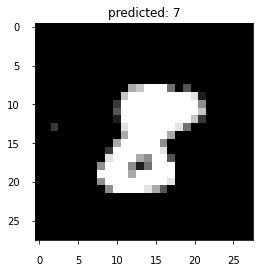

tensor([4.9270e-10, 9.0126e-09, 1.0000e+00, 4.5122e-12, 3.4076e-22, 1.3993e-09,
        5.2431e-13, 3.9875e-18, 1.5328e-09, 1.1064e-16],
       grad_fn=<SelectBackward>)


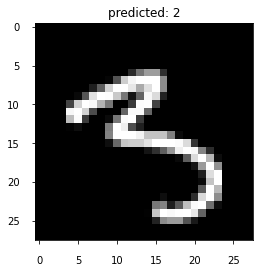

tensor([1.6124e-11, 9.9998e-01, 4.0230e-06, 1.6821e-08, 5.8121e-08, 8.6070e-09,
        7.2224e-12, 7.3269e-06, 5.7727e-06, 2.2635e-09],
       grad_fn=<SelectBackward>)


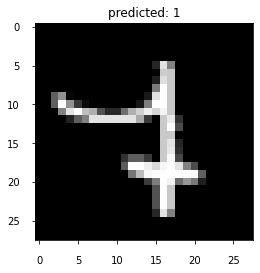

tensor([1.0000e+00, 1.6297e-08, 6.3652e-11, 3.8670e-12, 4.3049e-10, 2.8304e-09,
        5.8860e-08, 4.8369e-09, 3.1018e-13, 1.8701e-10],
       grad_fn=<SelectBackward>)


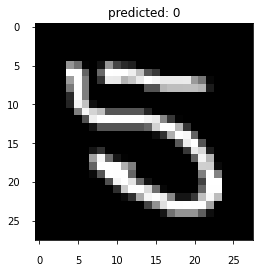

tensor([4.6211e-13, 4.3122e-10, 2.1455e-12, 3.1617e-11, 1.0000e+00, 4.9353e-14,
        1.3110e-13, 4.0685e-08, 8.6470e-13, 8.8055e-07],
       grad_fn=<SelectBackward>)


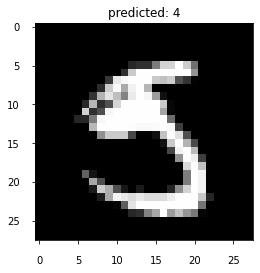

tensor([9.4232e-14, 9.9999e-01, 4.7623e-10, 4.3453e-11, 1.7875e-09, 2.6415e-12,
        4.7712e-15, 5.1174e-06, 1.1451e-09, 3.9510e-13],
       grad_fn=<SelectBackward>)


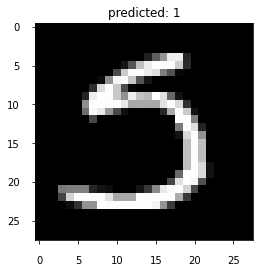

tensor([2.2682e-16, 1.7807e-07, 3.3007e-13, 3.5003e-08, 9.9998e-01, 1.7609e-09,
        3.9527e-16, 1.1153e-08, 1.7756e-05, 2.7533e-07],
       grad_fn=<SelectBackward>)


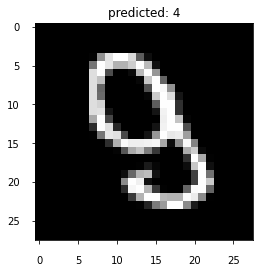

tensor([1.4117e-15, 1.7036e-07, 1.6760e-10, 2.7806e-07, 2.5143e-08, 3.1681e-11,
        1.4529e-23, 2.0553e-08, 2.1823e-11, 1.0000e+00],
       grad_fn=<SelectBackward>)


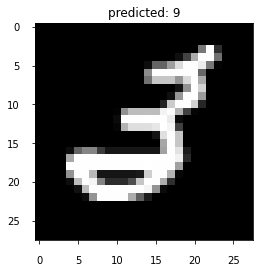

tensor([4.6440e-09, 5.8705e-10, 1.9194e-09, 6.2098e-10, 3.0199e-02, 7.5829e-01,
        1.0813e-01, 1.3187e-16, 3.7901e-02, 6.5480e-02],
       grad_fn=<SelectBackward>)


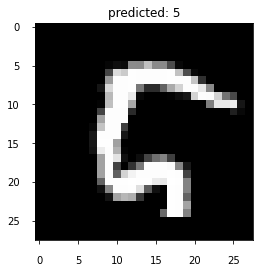

tensor([5.1242e-16, 9.0639e-17, 1.7029e-18, 6.3931e-11, 1.7817e-06, 5.2788e-14,
        7.6714e-27, 1.1602e-07, 8.7703e-11, 1.0000e+00],
       grad_fn=<SelectBackward>)


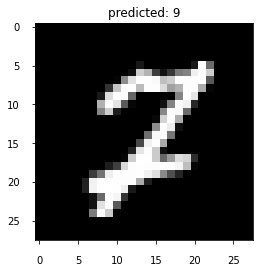

In [32]:
inds = torch.max(preds,dim=1)[0].argsort()[:10]
print(torch.max(preds,dim=1)[0][inds])
for i,im in enumerate(test_loader.dataset.data[inds]):
  plt.imshow(im,cmap='gray')
  plt.title(f'predicted: {preds[i].argmax()}')
  plt.show()

## _References_

- A very useful repository for a lot of Bayesian NN implementations: https://github.com/JavierAntoran/Bayesian-Neural-Networks
- The code for the paper is found at https://github.com/wjmaddox/drbayes and specifically the following notebook was adapted for this demonstration (https://github.com/wjmaddox/drbayes/blob/master/experiments/synthetic_regression/visualizing_uncertainty.ipynb)


In [16]:
!git config --global user.email "youmed.tech@gmail.com"
!git config --global user.name "ymohamedahmed"
!git --git-dir=drbayes/.git add -f drbayes/*.pt
!git --git-dir=drbayes/.git commit -m "updated checkpoints"
!git --git-dir=drbayes/.git push
# !cd ../

On branch master
Your branch is ahead of 'origin/master' by 1 commit.
  (use "git push" to publish your local commits)

Changes not staged for commit:
	deleted:    .gitignore
	deleted:    435_supplement.pdf
	deleted:    LICENSE
	deleted:    MLP-qmnist.pt
	deleted:    README.md
	deleted:    SIBDL_demo_group_13.ipynb
	deleted:    experiments/cifar_exps/README.md
	deleted:    experiments/cifar_exps/subspace_ess.py
	deleted:    experiments/cifar_exps/subspace_vi.py
	deleted:    experiments/cifar_exps/swag.py
	deleted:    experiments/data/MNIST/raw/train-images-idx3-ubyte
	deleted:    experiments/synthetic_regression/SIBDL-demo-group-13.ipynb
	deleted:    experiments/synthetic_regression/ckpts/curve.pt
	deleted:    experiments/synthetic_regression/ckpts/curve_parameters.npy
	deleted:    experiments/synthetic_regression/ckpts/data.npy
	deleted:    experiments/synthetic_regression/ckpts/sgd_checkpoint1.pt
	deleted:    experiments/synthetic_regression/ckpts/sgd_checkpoint2.pt
	deleted:    expe

In [20]:
!git --git-dir=drbayes/.git push

fatal: could not read Username for 'https://github.com': No such device or address


In [23]:
del preds
torch.cuda.empty_cache()